In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
infos = pd.read_csv('../../data/infos.csv', sep = '|')

In [4]:
items = pd.read_csv('../../data/items.csv', sep = '|')

In [5]:
orders = pd.read_csv('../../data/orders.csv', sep = '|', parse_dates=['time'])

## - Creating the structure

In [6]:
df = orders.copy()

In [7]:
df['weekpair'] = (df.time.dt.dayofyear + 1) // 14 - 13

In [8]:
npairs = df.weekpair.nunique()

In [9]:
n_items = items['itemID'].nunique()
print('total number of items:', n_items)
print('expected number of instances:', n_items * npairs)

total number of items: 10463
expected number of instances: 136019


In [10]:
mi = pd.MultiIndex.from_product([range(-npairs, 0), items['itemID']], names=['weekpair', 'itemID'])
data_temp = pd.DataFrame(index = mi)

In [11]:
data_temp = data_temp.join(df.groupby(['weekpair', 'itemID'])[['order']].sum(), how = 'left')

In [12]:
data_temp.fillna(0, inplace = True)

In [13]:
data_temp.groupby('itemID').count().min()

order    13
dtype: int64

In [14]:
# data_temp

## - Creating features

In [15]:
data = data_temp.reset_index()

In [16]:
items.head(2)

,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
0,1,0,1,4.38,1,1,1,8.84
1,2,0,2,3.00,1,2,1,16.92


In [17]:
# data = pd.merge(data, items[['itemID', 'manufacturer', 'category1', 'category2', 'category3']], on = 'itemID')
data = pd.merge(data, items, on = 'itemID')

In [21]:
# features = [
#     ('itemID', 'item'),
#     ('manufacturer', 'manuf'),
#     ('category1', 'cat1'),
#     ('category2', 'cat2'),
#     ('category3', 'cat3')
# ]
# for f, n in features:
#     if f not in data.columns:
#         print('ops', f)

In [22]:
# features = [('itemID', 'item')]

In [23]:
# # f, name = ('manufacturer', 'manuf')
# for f, name in features:
#     print(f)
#     temp = data.groupby([f, 'weekpair'])[['order']].sum()
#     shifted = temp.groupby(f)[['order']].shift(1)
#     new_feature_block = pd.DataFrame()
#     for n in range(3):
#         rolled = shifted.groupby(f, as_index = False)['order'].rolling(2 ** n).mean()
#         new_feature_block['%s_%d' % (name, 2 ** n)] = rolled.reset_index(0, drop = True) # rolling has a weird index behavior...
#     data = pd.merge(data, new_feature_block.reset_index(), on = [f, 'weekpair'])

In [18]:
def gbagg(data, group_cols, targeted_cols, out_names, function, as_index = False):
  
    X = data.values
    col = {c : i for i, c in enumerate(data.columns)}

    # values that are going to calculated
    new_feat = []
    
    # numbers of the columns
    gcols = [col[c] for c in group_cols]
    tcols = [col[c] for c in targeted_cols]
    
    interval = None
    a = None
    i = 0
    while i < len(X):
        a = X[i, gcols]

        # find the whole interval of this group
        j = i
        while j < len(X):
            if (X[j, gcols] != a).any():
                break
            j += 1
        interval = X[i:j, tcols]

        # apply function on interval, save in new feature
        output = function(interval)
        new_feat.append(output)

        # go to next group
        i = j
    
    idx = data.groupby(group_cols).size().index # this is actually fast...
    out_df = pd.DataFrame(new_feat, columns = out_names, index = idx)
        
    if not as_index:
        out_df.reset_index(inplace = True)
        
    return out_df

In [19]:
def gbtransf(data, group_cols, targeted_cols, out_names, function, params = dict()):
  
    X = data.values
    col = {c : i for i, c in enumerate(data.columns)}

    # values that are going to calculated
    new_feat = np.zeros((len(data), len(out_names)))
    
    # numbers of the columns
    gcols = [col[c] for c in group_cols]
    tcols = [col[c] for c in targeted_cols]
    
    interval = None
    a = None
    i = 0
    while i < len(X):
        a = X[i, gcols]

        # find the whole interval of this group
        j = i
        while j < len(X):
            if (X[j, gcols] != a).any():
                break
            j += 1
        interval = X[i:j, tcols]

        # apply function on interval, save in new feature
        output = function(interval, **params)
        new_feat[i:j] = output

        # go to next group
        i = j
    
    out_df = pd.DataFrame(new_feat, columns = out_names, index = data.index)
        
    return out_df

In [20]:
def shift_and_2n_window(x, ws):
#     out = pd.DataFrame(x)
#     out = out.shift()
#     out = out.rolling(2 ** n).mean()

    shifted = np.zeros_like(x) # output
    shifted[1:] = x[:-1] # shift
    out = np.zeros_like(x, dtype = float)
    
    # rolling mean
    total = shifted[:ws].sum()
    out[ws - 1] = total / ws
    for i in range(ws, len(out)):
        total = total - shifted[i - ws] + shifted[i]
        out[i] = total / ws
    out[:ws] = np.NaN # maybe ws -1 should be NaN as well for receiving one NaN value when ws > 1
    # out[0] = np.NaN # this is always NaN for a shift of 1
    return out

In [21]:
data.sort_values(['itemID', 'weekpair'], inplace = True)

In [22]:
# gbtransf(data, ['itemID', 'weekpair'], ['order'], ['out'], lambda x : np.ones_like(x))

In [23]:
shift_and_2n_window(np.array([1 , 2, 3, 4, 5, 6]), 2 ** 1)

array([nan, nan, 1.5, 2.5, 3.5, 4.5])

In [24]:
features = [('itemID', 'item')]

In [25]:
for f, name in features:
    print(f)
    new_feature_block = pd.DataFrame()
    for n in range(3):
        new_f = gbtransf(data, ['itemID'], ['order'], ['out'], shift_and_2n_window, {'ws' : 2 ** n})
        new_feature_block['%s_%d' % (name, 2 ** n)] = new_f['out']
#     data = pd.merge(data, new_feature_block.reset_index(), on = [f, 'weekpair'])
    data = pd.concat([data, new_feature_block], axis =  1)

itemID


In [26]:
data.count() # the larger the window, more NaN are expected

weekpair                  136019
itemID                    136019
order                     136019
brand                     136019
manufacturer              136019
customerRating            136019
category1                 136019
category2                 136019
category3                 136019
recommendedRetailPrice    136019
item_1                    125556
item_2                    115093
item_4                     94167
dtype: int64

In [27]:
def dist2firstvalue(x):
    out = np.zeros_like(x, dtype = float)
    first = np.NaN
    for i in range(len(x)):
        out[i] = first
        if x[i] != 0:
            first = i
            break
    if i == len(x) - 1:
        return out
    for j in range(int(first), len(x)):
        out[j] = j - first
        
    return out

In [29]:
dist2firstvalue(np.array([0 , 0, 0, 0])), dist2firstvalue(np.array([0 , 0, 3, 0, 5, 6]))

(array([nan, nan, nan, nan]), array([nan, nan,  0.,  1.,  2.,  3.]))

In [101]:
def dist2firstvalueLeak(x):
    out = np.zeros_like(x, dtype = float)
    for i in range(len(x)):
        if x[i] != 0:
            out[i] = 1
            break
        
    return out

In [102]:
dist2firstvalueLeak(np.array([0 , 0, 3, 0, 5, 6]))
# dist2firstvalue(np.array([0 , 0, 0, 0]))

array([0., 0., 1., 0., 0., 0.])

In [33]:
# def dist2lastpeak(x):
#     out = np.zeros_like(x, dtype = float)
#     peak = np.NaN
#     peak_val = 0
#     for i in range(0, len(x)):
#         out[i] = i - peak
#         if x[i] > peak_val:
#             peak = i
#             peak_val = x[i]
        
#     return out

In [103]:
# dist2lastpeak(np.array([0 , 0, 3, 0, 5, 6]))

In [104]:
data.sort_values(['itemID', 'weekpair'], inplace = True)

In [105]:
data['dist2firstvalueLeak'] = gbtransf(data, ['itemID'], ['order'], ['out'], dist2firstvalueLeak)['out']
# data['dist2lastpeak'] = gbtransf(data, ['itemID'], ['order'], ['out'], dist2lastpeak)['out']

In [106]:
data.fillna(0, inplace=True)

In [107]:
# checking if we got what we wanted
data.query('itemID == 1')

,weekpair,itemID,order,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,item_1,item_2,item_4,dist2firstvalueLeak
0,-13,1,0.0,0,1,4.38,1,1,1,8.84,0.0,0.0,0.00,0.0
1,-12,1,2.0,0,1,4.38,1,1,1,8.84,0.0,0.0,0.00,1.0
2,-11,1,313.0,0,1,4.38,1,1,1,8.84,2.0,1.0,0.00,0.0
3,-10,1,35.0,0,1,4.38,1,1,1,8.84,313.0,157.5,0.00,0.0
4,-9,1,3.0,0,1,4.38,1,1,1,8.84,35.0,174.0,87.50,0.0
5,-8,1,1.0,0,1,4.38,1,1,1,8.84,3.0,19.0,88.25,0.0
6,-7,1,1.0,0,1,4.38,1,1,1,8.84,1.0,2.0,88.00,0.0
7,-6,1,2.0,0,1,4.38,1,1,1,8.84,1.0,1.0,10.00,0.0
8,-5,1,299.0,0,1,4.38,1,1,1,8.84,2.0,1.5,1.75,0.0
9,-4,1,3.0,0,1,4.38,1,1,1,8.84,299.0,150.5,75.75,0.0


In [108]:
# data['weekswithtrans'] = data.groupby('itemID')['order'].apply(lambda x : (x > 0).cumsum()) / (data['weekpair'] + 14)

In [109]:
counts = data.groupby('itemID')['order'].apply(lambda x : (x > 0).sum())

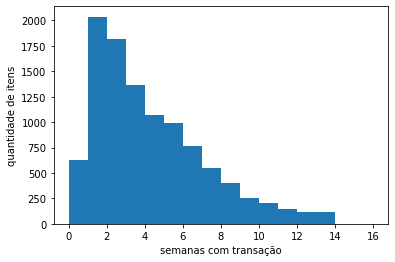

In [110]:
plt.hist(counts, bins = range(17))
plt.ylabel('quantidade de itens')
plt.xlabel('semanas com transação')
plt.show()

In [111]:
# f = 'itemID'
# temp = data.groupby([f, 'week'])[['order']].sum()
# shifted = temp.groupby(f)[['order']].shift(1)
# data['feature'] = (shifted.fillna(0) > 0).groupby(f)[['order']].cumsum().values

In [112]:
data.head()

,weekpair,itemID,order,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,item_1,item_2,item_4,dist2firstvalueLeak
0,-13,1,0.0,0,1,4.38,1,1,1,8.84,0.0,0.0,0.0,0.0
1,-12,1,2.0,0,1,4.38,1,1,1,8.84,0.0,0.0,0.0,1.0
2,-11,1,313.0,0,1,4.38,1,1,1,8.84,2.0,1.0,0.0,0.0
3,-10,1,35.0,0,1,4.38,1,1,1,8.84,313.0,157.5,0.0,0.0
4,-9,1,3.0,0,1,4.38,1,1,1,8.84,35.0,174.0,87.5,0.0


##  - Split Data

In [113]:
filtered_data = data

In [142]:
sub_week = -1
train = filtered_data.query('-13 <= weekpair <= (@sub_week - 2)').reset_index(drop = True)
full_train = filtered_data.query('-13 <= weekpair <= (@sub_week - 1)').reset_index(drop = True)
val = filtered_data.query('weekpair == (@sub_week - 1)').reset_index(drop = True)
sub = filtered_data.query('weekpair == (@sub_week)').reset_index(drop = True)

In [143]:
len(train), len(val), len(sub)

(115093, 10463, 10463)

In [144]:
weights = infos.set_index('itemID')['simulationPrice'].to_dict()

In [145]:
train.columns

Index(['weekpair', 'itemID', 'order', 'brand', 'manufacturer',
       'customerRating', 'category1', 'category2', 'category3',
       'recommendedRetailPrice', 'item_1', 'item_2', 'item_4',
       'dist2firstvalueLeak'],
      dtype='object')

In [146]:
y_train = train.pop('order').values
y_full_train = full_train.pop('order').values
y_val = val.pop('order').values
y_sub = sub.pop('order').values

X_train = train.values
X_full_train = full_train.values
X_val = val.values
X_sub = sub.values

w_train = train['itemID'].map(weights)
w_full_train = full_train['itemID'].map(weights)
w_val = val['itemID'].map(weights)
w_sub = sub['itemID'].map(weights)

<hr>

## - Min Expected Error

In [147]:
def evaluate(prediction, target, simulationPrice):
    return np.sum((prediction - np.maximum(prediction - target, 0) * 1.6)  * simulationPrice)

In [148]:
# max expected rmse
from sklearn.metrics import mean_squared_error as mse
# pred = data.loc[1:12].groupby('itemID')['order'].mean().sort_index()
# target_week = data.loc[13:, 'order'].reset_index(level = 0, drop = True).sort_index()
# mse(target_week, pred) ** .5

<hr>

## - XGBoost

In [149]:
import xgboost as xgb

In [150]:
xgb.__version__

'1.1.0'

In [151]:
# custom objective

def gradient(prediction, dtrain):
    y = dtrain.get_label()
#     prediction.astype(int)
#     prediction = np.minimum(prediction.astype(int), 1)
    return -2 * (prediction - np.maximum(prediction - y, 0) * 1.6) * (1 - (prediction > y) * 1.6)

def hessian(prediction, dtrain):
    y = dtrain.get_label()
#     prediction.prediction(int)
#     prediction = np.minimum(prediction.astype(int), 1)
    return -2 * (1 - (prediction > y) * 1.6) ** 2

def objective(prediction, dtrain):
    w = dtrain.get_weight()
    grad = gradient(prediction, dtrain) * w
    hess = hessian(prediction, dtrain) * w
    return grad, hess

In [152]:
# custom feval

def feval(prediction, dtrain):
    prediction = prediction.astype(int)
#     predt = np.minimum(predt.astype(int), 1)
    target = dtrain.get_label()
    simulationPrice = dtrain.get_weight()
    return 'feval', np.sum((prediction - np.maximum(prediction - target, 0) * 1.6)  * simulationPrice)

In [153]:
dtrain = xgb.DMatrix(X_train, y_train, w_train, missing = -999)
dfulltrain = xgb.DMatrix(X_full_train, y_full_train, w_full_train, missing = -999)
dval = xgb.DMatrix(X_val, y_val, w_val, missing = -999)
dsub = xgb.DMatrix(X_sub, y_sub, w_sub, missing = -999)
# specify parameters via map
param = {
    'max_depth':10,
    'eta':0.005,
    'objective':'reg:squarederror',
    'disable_default_eval_metric': 1,
#     'tree_method' : 'gpu_hist',
}
num_round = 200
bst = xgb.train(param, dtrain,
                num_round,
                early_stopping_rounds = 30,
                evals = [(dtrain, 'train'), (dval, 'val')],
#                 obj = objective,
                feval = feval,
                maximize = True,
                )

[0]	train-feval:130578.61800	val-feval:14003.92400
Multiple eval metrics have been passed: 'val-feval' will be used for early stopping.

Will train until val-feval hasn't improved in 30 rounds.
[1]	train-feval:298002.28792	val-feval:26863.46196
[2]	train-feval:485408.61184	val-feval:49234.78198
[3]	train-feval:703376.84990	val-feval:73677.97397
[4]	train-feval:852346.02610	val-feval:86166.47597
[5]	train-feval:1003731.56225	val-feval:98456.19796
[6]	train-feval:1168661.57212	val-feval:109510.11994
[7]	train-feval:1288984.89422	val-feval:119135.06194
[8]	train-feval:1475870.45026	val-feval:133675.51398
[9]	train-feval:1630356.33795	val-feval:144401.26998
[10]	train-feval:1873078.75636	val-feval:162218.07602
[11]	train-feval:2026791.19454	val-feval:174309.81995
[12]	train-feval:2242418.42458	val-feval:185354.05402
[13]	train-feval:2400483.42239	val-feval:198551.44400
[14]	train-feval:2494699.16843	val-feval:202349.12603
[15]	train-feval:2622870.29448	val-feval:212185.32409
[16]	train-fev

[148]	train-feval:12803178.05199	val-feval:546165.85769
Stopping. Best iteration:
[118]	train-feval:11297218.43892	val-feval:581618.78627



In [154]:
prediction = bst.predict(dsub, ntree_limit=bst.best_ntree_limit).astype(int)
evaluate(prediction, y_sub, w_sub)

631571.2659999998

In [155]:
# retrain!

In [156]:
bst_sub = xgb.train(param, dfulltrain,
    num_boost_round = bst.best_ntree_limit, early_stopping_rounds = 5,
    #                 obj = objective,
    feval = feval, maximize = True,
    evals = [(dfulltrain, 'ftrain')],
    verbose_eval = False,
)

In [157]:
prediction = bst_sub.predict(dsub, ntree_limit=bst_sub.best_ntree_limit).astype(int)
evaluate(prediction, y_sub, w_sub)

524715.0119999999

In [91]:
# some other things below

In [92]:
# max possible score
evaluate(y_sub, y_sub, w_sub)

7683293.24

In [541]:
# using previous weekpair
evaluate(y_val, y_sub, w_sub)

-3425880.0980000007

In [325]:
submission = items[['itemID']].copy()
submission['demandPrediction'] = bst.predict(dsub, ntree_limit=bst.best_ntree_limit).astype(int)
submission.to_csv('../../submissions/sub_inclass_03.csv', sep = '|', index=False)
# submission.head()

<hr>

## - LGBM

In [159]:
def feval_lgbm(prediction, dtrain):
    prediction = prediction.astype(int)
    target = dtrain.get_label()
    simulationPrice = dtrain.get_weight()
    return 'feval', np.sum((prediction - np.maximum(prediction - target, 0) * 1.6)  * simulationPrice), True

In [172]:
import lightgbm as lgb

params = {
          "objective" : 'regression_l1',
#           "metric" :"rmse",
          "learning_rate" : 0.05,
          'verbosity': 2,
#           'max_depth': 6,
#           'num_leaves': 15,
          "min_data_in_leaf":1500
         }
# https://lightgbm.readthedocs.io/en/latest/Parameters.html


ds_params = {
#     'categorical_feature' : [8, 9, 10],
}
lgbtrain = lgb.Dataset(X_train, label = y_train, weight=w_train, **ds_params)
lgbfulltrain = lgb.Dataset(X_full_train, label = y_full_train, weight=w_full_train, **ds_params)
lgbvalid = lgb.Dataset(X_val, label = y_val, weight=w_val, **ds_params)
lgbsubmis = lgb.Dataset(X_sub, label = y_sub, weight=w_sub, **ds_params)

num_round = 1000
lgb_model = lgb.train(params,
                  lgbtrain,
                  num_round,
                  valid_sets = [lgbtrain, lgbvalid],
                  valid_names = ['train', 'val'],
                  verbose_eval=5,
                  early_stopping_rounds=5,
                  feval = feval_lgbm,
#                   fobj = objective,
                 )

Training until validation scores don't improve for 5 rounds
[5]	train's l1: 4.60933	train's feval: 1.1929e+06	val's l1: 6.12105	val's feval: 54562.4
[10]	train's l1: 4.4976	train's feval: 3.0359e+06	val's l1: 6.01632	val's feval: 204104
[15]	train's l1: 4.45259	train's feval: 3.72497e+06	val's l1: 5.97382	val's feval: 269831
[20]	train's l1: 4.42003	train's feval: 4.33319e+06	val's l1: 5.9382	val's feval: 311477
[25]	train's l1: 4.39785	train's feval: 4.75345e+06	val's l1: 5.92327	val's feval: 348151
[30]	train's l1: 4.38512	train's feval: 5.0382e+06	val's l1: 5.90955	val's feval: 360971
[35]	train's l1: 4.37291	train's feval: 5.3883e+06	val's l1: 5.89516	val's feval: 395389
[40]	train's l1: 4.36097	train's feval: 5.62592e+06	val's l1: 5.8834	val's feval: 411406
[45]	train's l1: 4.35725	train's feval: 5.68121e+06	val's l1: 5.87762	val's feval: 420400
[50]	train's l1: 4.35453	train's feval: 5.74903e+06	val's l1: 5.87281	val's feval: 428064
[55]	train's l1: 4.34992	train's feval: 5.84219

In [173]:
prediction = lgb_model.predict(X_sub, num_iteration=lgb_model.best_iteration).astype(int)
evaluate(prediction, y_sub, w_sub)

852638.408

In [174]:
# retrain!

In [175]:
lgb_model_sub = lgb.train(params,
                  lgbfulltrain,
                  lgb_model.best_iteration,
                  valid_sets = [lgbfulltrain],
                  valid_names = ['train'],
                  verbose_eval=5,
                  early_stopping_rounds=5,
                 feval = feval_lgbm,
#                   fobj = objective,
                 )

Training until validation scores don't improve for 5 rounds
[5]	train's l1: 4.72377	train's feval: 1.45205e+06
[10]	train's l1: 4.63331	train's feval: 3.06341e+06
[15]	train's l1: 4.59507	train's feval: 3.6609e+06
[20]	train's l1: 4.61191	train's feval: 3.53721e+06
[25]	train's l1: 4.66227	train's feval: 3.50389e+06
[30]	train's l1: 4.69321	train's feval: 3.04971e+06
[35]	train's l1: 4.70075	train's feval: 3.02904e+06
[40]	train's l1: 4.71441	train's feval: 3.00331e+06
[45]	train's l1: 4.72791	train's feval: 3.04155e+06
[50]	train's l1: 4.74702	train's feval: 2.6162e+06
[55]	train's l1: 4.75423	train's feval: 2.84078e+06
[60]	train's l1: 4.76259	train's feval: 2.50595e+06
[65]	train's l1: 4.76465	train's feval: 2.64505e+06
[70]	train's l1: 4.76247	train's feval: 2.89819e+06
[75]	train's l1: 4.75908	train's feval: 2.88661e+06
[80]	train's l1: 4.76195	train's feval: 2.723e+06
[85]	train's l1: 4.76428	train's feval: 2.75881e+06
[90]	train's l1: 4.76211	train's feval: 2.86185e+06
[95]	trai

In [176]:
prediction = lgb_model_sub.predict(X_sub, num_iteration=lgb_model_sub.best_iteration).astype(int)
evaluate(prediction, y_sub, w_sub)

362890.07999999996

<hr>

## - CatBoost

In [177]:
from catboost import CatBoost, CatBoostRegressor, Pool

In [178]:
class feval_cat(object):
    def get_final_error(self, error, weight):
        # return error / (weight + 1e-38)
        return error

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, simulationPrice):
        prediction = np.array(approxes[0]).astype(int)
        target = np.array(target[0]).astype(int)
        simulationPrice = np.array(simulationPrice[0])
        score = np.sum((prediction - np.maximum(prediction - target, 0) * 1.6)  * simulationPrice)
#         print('score', score)
#         print(type(prediction), type(target), type(simulationPrice))
        return np.sum((prediction - np.maximum(prediction - target, 0) * 1.6)  * simulationPrice), 0

In [182]:
ds_params = {
#     'cat_features' : [8, 9, 10],
}
train_pool = Pool(X_train, label = y_train, weight = w_train, **ds_params)
trainfull_pool = Pool(X_full_train, label = y_full_train, weight = w_full_train, **ds_params)
val_pool = Pool(X_val, label = y_val, weight = w_sub, **ds_params)
sub_pool = Pool(X_sub, label = y_sub, weight = w_sub, **ds_params)


model = CatBoostRegressor(
#     iterations = 2,
#     depth=6, 
    learning_rate=0.1, 
    loss_function='MAE',
    early_stopping_rounds=5,
    eval_metric = feval_cat(),
    thread_count=-1,
)

model.fit(
    train_pool,
    eval_set=[train_pool, val_pool],
#     logging_level='Verbose',  # you can uncomment this for text output

);


0:	learn: -87609.0617051	test: -87609.0617051	test1: -11810.8622299	best: -11810.8622299 (0)	total: 72.2ms	remaining: 1m 12s
1:	learn: -132434.3605775	test: -132434.3605775	test1: -15214.7942961	best: -11810.8622299 (0)	total: 136ms	remaining: 1m 7s
2:	learn: -132434.3605775	test: -132434.3605775	test1: -15214.7942961	best: -11810.8622299 (0)	total: 200ms	remaining: 1m 6s
3:	learn: -132434.3605775	test: -132434.3605775	test1: -15214.7942961	best: -11810.8622299 (0)	total: 263ms	remaining: 1m 5s
4:	learn: -132434.3605775	test: -132434.3605775	test1: -15214.7942961	best: -11810.8622299 (0)	total: 330ms	remaining: 1m 5s
5:	learn: -201362.9559191	test: -201362.9559191	test1: -22718.2624422	best: -11810.8622299 (0)	total: 394ms	remaining: 1m 5s
Stopped by overfitting detector  (5 iterations wait)

bestTest = -11810.86223
bestIteration = 0

Shrink model to first 1 iterations.


In [183]:
prediction = model.predict(X_sub, ntree_end = model.best_iteration_).astype(int)
evaluate(prediction, y_sub, w_sub)

279277.73799999995

In [489]:
# retrain!

In [490]:
cat_sub = CatBoostRegressor(
#     iterations = 2,
#     depth=6, 
#     learning_rate=0.1, 
    loss_function='MAE',
    early_stopping_rounds=5,
    eval_metric = feval_cat(),
    thread_count=-1,
)
cat_sub.fit(
    trainfull_pool,
    eval_set=[trainfull_pool],
#     logging_level='Verbose',  # you can uncomment this for text output

);

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 79.2ms	remaining: 1m 19s
1:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 148ms	remaining: 1m 13s
2:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 215ms	remaining: 1m 11s
3:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 281ms	remaining: 1m 10s
4:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 352ms	remaining: 1m 10s
5:	learn: -298.4100058	test: -298.4100058	best: 0.0000000 (0)	total: 422ms	remaining: 1m 9s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0
bestIteration = 0

Shrink model to first 1 iterations.


In [491]:
prediction = cat_sub.predict(X_sub, ntree_end = cat_sub.best_iteration_).astype(int)
evaluate(prediction, y_sub, w_sub)

0.0

<hr>

## - Ensemble

In [184]:
cat_w = 0
lgb_w = 1
xgb_w = 1
ensemble = model.predict(X_sub, ntree_end = model.best_iteration_) * cat_w
ensemble += lgb_model.predict(X_sub, num_iteration=lgb_model.best_iteration) * lgb_w
ensemble += bst.predict(dsub, ntree_limit=bst.best_ntree_limit) * xgb_w
ensemble = ensemble / (cat_w + lgb_w + xgb_w)
evaluate(ensemble.astype(int), y_sub, w_sub)

905239.624

<hr>

## - Linear Regression

In [270]:
from sklearn.linear_model import LinearRegression
# from sklearn.metrics import 

In [271]:
lr = LinearRegression()

In [272]:
lr.fit(X_train, y_train, w_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [273]:
print('train', evaluate(lr.predict(X_train), y_train, w_train))
print('test', evaluate(lr.predict(X_test), y_test, w_test))
print('sub', evaluate(lr.predict(X_sub), y_sub, w_sub))

train -21058674.042366117
test -2602271.639547858
sub -2761693.8996196142


<hr>

In [ ]:
# fazer feature que pega o percentil de quando o item deu de dinheiro dentro de uma categoria
# fazer features que pega dist de atual até o pico mais alto
# dist do maior pico pro segundo
# min(dist(terceiro, primeiro), dist(terceiro, segundo))